# Imports

In [1]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da
import models.resnet as resnet

2024-06-03 13:59:03.557356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 13:59:04.084074: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-03 13:59:04.084131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-03 13:59:04.084139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load Dataset

In [15]:
# load data
thismodule = sys.modules[__name__]

with np.load('data/PTB_XL_HB_1s_window.npz', allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

# Data Augmentation + Pair Generation

In [2]:
def mask_ecg(ecg, mask_ratio=0.1):
    block_size = 20
    
    for lead in range(ecg.shape[1]):
        for i in range(0, ecg.shape[0], block_size):
            if random.random() < mask_ratio:
                ecg[i:i+block_size, lead] = 0
    return ecg

def mask_lead(ecg, mask_ratio=0.1):

    for lead in range(ecg.shape[1]):
        if random.random() < mask_ratio:
            ecg[:, lead] = 0
    return ecg

In [3]:
def augment_ecg_signal(signal):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(1.5,2.5), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0, 0.2))
    # res = mask_ecg(noised_drifted_signal, mask_ratio=0.1) if random.random() < 0.5 else mask_lead(noised_drifted_signal, mask_ratio=0.2)
    res = noised_drifted_signal
    return res

def generate_augmented_pairs(batch):
    augmented_batch_1 = np.array([augment_ecg_signal(x) for x in batch])
    augmented_batch_2 = np.array([augment_ecg_signal(x) for x in batch])
    return augmented_batch_1, augmented_batch_2

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# MoCo class

In [37]:
# Define the MoCo Queue
class MoCo:
    def __init__(self, input_shape, projection_dim, queue_size=65536, temperature=0.1):
        self.projection_dim = projection_dim
        self.queue_size = queue_size
        self.temperature = temperature
        self.queue_ptr = 0

        # Initialize the feature extractor and projection head
        self.model = self.create_model(input_shape)

        # Initialize the queue
        self.queue = tf.random.normal([queue_size, projection_dim])

    def enqueue(self, features):
        batch_size = features.shape[0]
        replace_indices = tf.range(self.queue_ptr, self.queue_ptr + batch_size) % self.queue_size
        self.queue = tf.tensor_scatter_nd_update(self.queue, tf.expand_dims(replace_indices, 1), features)
        self.queue_ptr = (self.queue_ptr + batch_size) % self.queue_size

    def dequeue(self):
        return self.queue
    
    def _dequeue_and_enqueue(self, keys):
        keys = concat_all_gather(keys)
        batch_size = tf.shape(keys)[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size].assign(tf.transpose(keys))
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr.assign(ptr)
    
    def projection_head(self, X):
        X = keras.layers.Dense(self.projection_dim, activation='relu', name='dense_proj_1')(X)
        X = keras.layers.Dense(self.projection_dim, name='dense_proj_2')(X)
        return X
    
    def create_model(self, input_shape):
        X_input = keras.Input(input_shape)
        _, fe = resnet.model(X_input, num_classes=5, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        out = self.projection_head(fe)
        return keras.Model(inputs=X_input, outputs=out)
    
    def nt_xent_loss(self, queries, keys):
        logits = tf.matmul(queries, keys, transpose_b=True) / self.temperature
        batch_size = tf.shape(logits)[0]
        labels = tf.range(batch_size)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        return tf.reduce_mean(loss)

    # @tf.function
    def training_step(self, batch, optimizer):
        with tf.GradientTape() as tape:
            queries = self.model(batch[0], training=True)
            keys = self.model(batch[1], training=True)

            # Normalize
            queries = tf.math.l2_normalize(queries, axis=1)
            keys = tf.math.l2_normalize(keys, axis=1)

            # Get queue keys
            queue_keys = self.dequeue()

            # Compute loss
            all_keys = tf.concat([keys, queue_keys], axis=0)
            loss = self.nt_xent_loss(queries, all_keys)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Update queue
        self.enqueue(keys)

        return loss
    
    def train(self, dataset, optimizer, epochs, steps_per_epoch, name):
        for epoch in range(epochs):
            total_steps = len(dataset)
            for step, batch in enumerate(dataset):
                loss = self.training_step(batch, optimizer)
                if step % 100 == 0:
                    print(f"Epoch {epoch+1}, Step {step}/{total_steps}, Loss: {loss.numpy()}")
            # Save model
            print(f"Saving model for epoch {epoch+1}")
            self.model.save(f"model-weights/test_moco_{name}_{epoch+1}.h5")

# Training

In [20]:
# ecg_dataset = tf.data.Dataset.from_tensor_slices(X_train)
# ecg_dataset = ecg_dataset.shuffle(buffer_size=1024).batch(32)

dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)
augmented_dataset = dataset.map(lambda x: tf.py_function(generate_augmented_pairs, [x], [tf.float32, tf.float32])).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
input_shape = X_train.shape[1:]
print(input_shape)
projection_dim = 128
temperature = 0.1
queue_size = 65536
batch_size = 32
epochs = 3
steps_per_epoch = 1000

(100, 12)


In [5]:
def mask_ecg(ecg, mask_ratio=0.1, block_size=20):
    ecg_shape = tf.shape(ecg)
    num_blocks = ecg_shape[0] // block_size
    
    mask = tf.random.uniform([num_blocks, ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.reshape(tf.tile(mask[:, None, :], [1, block_size, 1]), ecg_shape)
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

def mask_lead(ecg, mask_ratio=0.1):
    ecg_shape = tf.shape(ecg)
    
    mask = tf.random.uniform([ecg_shape[1]], minval=0, maxval=1) < mask_ratio
    mask = tf.tile(mask[None, :], [ecg_shape[0], 1])
    
    return tf.where(mask, tf.zeros_like(ecg), ecg)

In [21]:
moco = MoCo(input_shape, projection_dim, queue_size, temperature)


In [22]:
optim = keras.optimizers.Adam(learning_rate=0.001)
moco.train(augmented_dataset, optim, epochs, steps_per_epoch)

2024-06-03 12:50:42.470414: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-06-03 12:50:43.760081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-03 12:50:44.216361: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x921196d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-03 12:50:44.216381: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-06-03 12:50:44.227313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-03 12:50:44.350532: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of t

Epoch 1, Step 0/7180, Loss: 36.679237365722656


KeyboardInterrupt: 

In [17]:
# save the model
moco.model.save('model-weights/test_moco_model.h5')

# Visaulization of representations

In [19]:
model = keras.models.load_model('model-weights/test_moco_3.h5')

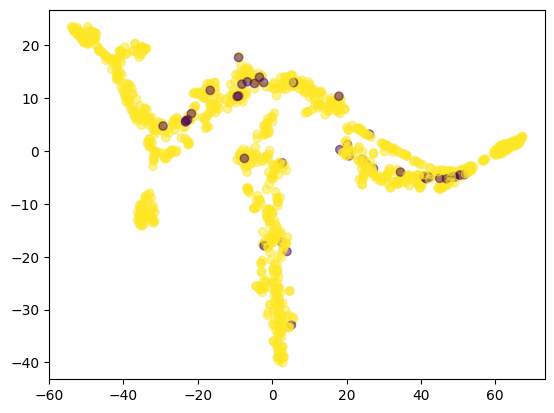

In [23]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.show()


labels_Norm = [0 if "STTC" in x else 1 for x in Y_train_text[:1000]]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]


plot_tsne(model, X_train[:1000], labels=labels_Norm)

# Finetuning

In [25]:
print(X_train.shape)

(229753, 100, 12)


In [26]:
X_input = keras.Input(shape=X_train.shape[1:])
num_classes = 5
out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)

fine_tuned_model = keras.Model(inputs=X_input, outputs=out)

optimizer = keras.optimizers.Adam(learning_rate=0.001)
fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
fine_tuned_model.summary()

fine_tuned_model.load_weights('models/test_moco_3.h5', by_name=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 96, 16)       976         ['input_4[0][0]']                
                                                                                                  
 bn1 (BatchNormalization)       (None, 96, 16)       64          ['conv1[0][0]']                  
                                                                                                  
 activation_63 (Activation)     (None, 96, 16)       0           ['bn1[0][0]']                    
                                                                                            

In [27]:
# freeze weights of the encoder

texts = [f"_{i}_" for i in range(1, 8)]
print(texts)

for layer in fine_tuned_model.layers:
    if any([text in layer.name for text in texts]):
        print(f"Freezing layer {layer.name}")
        layer.trainable = False

['_1_', '_2_', '_3_', '_4_', '_5_', '_6_', '_7_']
Freezing layer conv_1_1
Freezing layer bn_1_1
Freezing layer conv_1_2
Freezing layer bn_1_2
Freezing layer conv_2_1
Freezing layer bn_2_1
Freezing layer conv_2_2
Freezing layer bn_2_2
Freezing layer conv_3_1
Freezing layer bn_3_1
Freezing layer conv_3_2
Freezing layer bn_3_2
Freezing layer conv_4_1
Freezing layer bn_4_1
Freezing layer conv_4_2
Freezing layer bn_4_2
Freezing layer conv_5_1
Freezing layer bn_5_1
Freezing layer conv_5_2
Freezing layer bn_5_2
Freezing layer conv_6_1
Freezing layer bn_6_1
Freezing layer conv_6_2
Freezing layer bn_6_2
Freezing layer conv_7_1
Freezing layer bn_7_1
Freezing layer conv_7_2
Freezing layer bn_7_2


In [28]:
# finetune the model

batch_size = 32
data_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = fine_tuned_model.fit(data_generator, epochs=5, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

Epoch 1/5
7179/7179 [==============================] - 170s 23ms/step - loss: 0.3547 - accuracy: 0.6504 - precision: 0.7550 - recall: 0.5983 - binary_accuracy: 0.8507 - val_loss: 0.3047 - val_accuracy: 0.6960 - val_precision: 0.7876 - val_recall: 0.6689 - val_binary_accuracy: 0.8712
Epoch 2/5
7179/7179 [==============================] - 162s 23ms/step - loss: 0.2866 - accuracy: 0.7093 - precision: 0.8059 - recall: 0.6961 - binary_accuracy: 0.8816 - val_loss: 0.2890 - val_accuracy: 0.7028 - val_precision: 0.7984 - val_recall: 0.6886 - val_binary_accuracy: 0.8778
Epoch 3/5
7179/7179 [==============================] - 161s 22ms/step - loss: 0.2687 - accuracy: 0.7226 - precision: 0.8149 - recall: 0.7196 - binary_accuracy: 0.8886 - val_loss: 0.3016 - val_accuracy: 0.6998 - val_precision: 0.7862 - val_recall: 0.7096 - val_binary_accuracy: 0.8783
Epoch 4/5
7179/7179 [==============================] - 164s 23ms/step - loss: 0.2580 - accuracy: 0.7296 - precision: 0.8217 - recall: 0.7334 - binar

In [29]:
# evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_binary_accuracy = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test Binary Accuracy: {test_binary_accuracy}, F1 Score: {2 * (test_precision * test_recall) / (test_precision + test_recall)}")

923/923 [==============================] - 5s 5ms/step - loss: 0.2870 - accuracy: 0.7069 - precision: 0.7889 - recall: 0.7147 - binary_accuracy: 0.8811
Test Loss: 0.2869873344898224, Test Accuracy: 0.7068907022476196, Test Precision: 0.7889058589935303, Test Recall: 0.7146541476249695, Test Binary Accuracy: 0.881055474281311, F1 Score: 0.749946582422524


In [30]:
# save the model
fine_tuned_model.save('model-weights/moco_v2_finetuned_ptbxl_model.h5')

# BARD

In [4]:
# load Data
import sys
thismodule = sys.modules[__name__]

with np.load('data/BARD.npz', allow_pickle=True) as data:
    for k in data.keys():
        setattr(thismodule, k, data[k])
            
print(ecgs.shape, ecgs_HB.shape, ecgs_HB_patients.shape, ecgs_HB_samples.shape)

(717,) (14751, 100, 12) (14751,) (14751,)


In [7]:
# num_classes = 5
# X_input = keras.Input(shape=ecgs_HB.shape[1:])

# _, fe = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
# out = projection_head(fe)


# model = keras.Model(inputs=X_input, outputs=out)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
# model.summary()

NameError: name 'X_train' is not defined

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(ecgs_HB).batch(32)
augmented_dataset = dataset.map(lambda x: tf.py_function(generate_augmented_pairs, [x], [tf.float32, tf.float32])).prefetch(tf.data.AUTOTUNE)

In [34]:
input_shape = ecgs_HB.shape[1:]
print(input_shape)
projection_dim = 128
temperature = 0.1
queue_size = 65536
batch_size = 32
epochs = 10
steps_per_epoch = 1000

(100, 12)


In [38]:
moco = MoCo(input_shape, projection_dim, queue_size, temperature)
optim = keras.optimizers.Adam(learning_rate=0.001)

In [39]:
moco.train(augmented_dataset, optim, epochs, steps_per_epoch, "BARD")

Epoch 1, Step 0/461, Loss: 37.413841247558594
Epoch 1, Step 100/461, Loss: 22.321773529052734
Epoch 1, Step 200/461, Loss: 21.533599853515625
Epoch 1, Step 300/461, Loss: 21.10629653930664
Epoch 1, Step 400/461, Loss: 20.79467010498047
Saving model for epoch 1
Epoch 2, Step 0/461, Loss: 20.63163185119629
Epoch 2, Step 100/461, Loss: 20.401683807373047
Epoch 2, Step 200/461, Loss: 20.122817993164062
Epoch 2, Step 300/461, Loss: 19.85586166381836
Epoch 2, Step 400/461, Loss: 19.567283630371094
Saving model for epoch 2
Epoch 3, Step 0/461, Loss: 19.33260154724121
Epoch 3, Step 100/461, Loss: 19.132598876953125
Epoch 3, Step 200/461, Loss: 18.77218246459961
Epoch 3, Step 300/461, Loss: 18.303714752197266
Epoch 3, Step 400/461, Loss: 17.866802215576172
Saving model for epoch 3
Epoch 4, Step 0/461, Loss: 17.56917953491211
Epoch 4, Step 100/461, Loss: 17.084535598754883
Epoch 4, Step 200/461, Loss: 16.343948364257812
Epoch 4, Step 300/461, Loss: 15.685066223144531
Epoch 4, Step 400/461, Loss:

In [7]:
model = keras.models.load_model('model-weights/test_moco_BARD_6.h5')

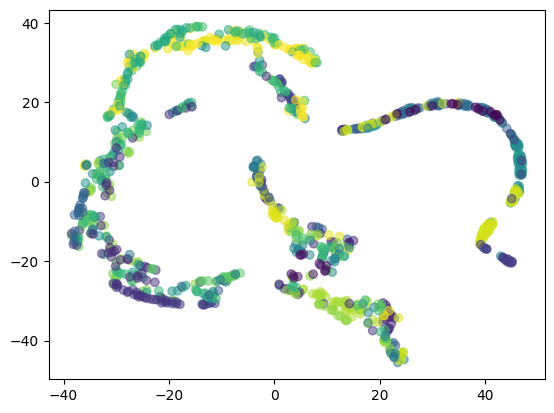

In [8]:
# tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model, signals, labels):
    representations = model(signals)
    tsne = TSNE(n_components=2, perplexity=20, n_iter=1000)
    tsne_transformed = tsne.fit_transform(representations)
    plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.show()


labels_Norm = ecgs_HB_patients[:1000]
# labels_Norm = [0 if len(x)==0 else 1 for x in Z_HB_text[:1000]]


plot_tsne(model, ecgs_HB[:1000], labels=labels_Norm)